## Gesture Recognition Case Study

<font color="black"> **Authors**: Shrinivas Dhamone and Abu Saleha </font>


# <font color="blue">Problem Statement:</font>

<font color="green">Imagine yourself as a data scientist working for a company that makes really advanced smart TVs for homes. Your job is to create a cool feature for these smart TVs. This feature lets the TV recognize five different hand movements that a person does, and these movements can control the TV without needing a remote.</font>

<font color="purple">A special camera on the TV keeps an eye on these hand movements. Each hand movement corresponds to a specific thing the TV should do:</font>

 - <font color="red">**Thumbs Up**:</font> <font color="orange">Makes the sound louder.</font>
 - <font color="red">**Thumbs Down**:</font> <font color="orange">Makes the sound softer.</font>
 - <font color="red">**Left Swipe**:</font> <font color="orange">Takes the movie back by 10 seconds.</font>
 - <font color="red">**Right Swipe**:</font> <font color="orange">Takes the movie forward by 10 seconds.</font>
 - <font color="red">**Stop**:</font> <font color="orange">Pauses the movie.</font>


In [ ]:
# # Mount the drive to google colab notebook
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# Running !nvidia-smi will output information about the NVIDIA GPUs installed on the system,
!nvidia-smi

Sun Dec 24 11:50:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:3D:00.0 Off |                  Off |
| 30%   27C    P8              15W / 300W |      2MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# import important libraries
import numpy as np
import pandas as pd
import os
from skimage.io import imread
from skimage.transform import resize as imresize
import cv2
import matplotlib.pyplot as plt
import datetime

In [3]:
# Import all the required Keras modules
from keras.models import Sequential, Model, load_model
from keras.layers import GlobalAveragePooling2D, Input, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers
from keras.layers import Dense, GRU, Flatten, TimeDistributed
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16 
#from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import LeakyReLU
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
#Ensures consistent random number sequences in NumPy.
import random as rn
rn.seed(30) 

# Keras and TensorFlow
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)  # Setting seed for TensorFlow's random number generator

# Display TensorFlow version
print("TensorFlow Version:", tf.__version__)

# Generate a random integer using NumPy's random number generator
random_integer = rn.randint(1, 9999)
print("Random Integer:", random_integer)

2.7.0
8833


#### <font color="purple"> Loading data from CSV files & configuring the batch size for training.</font>

- <font color="purple">readlines() reads the lines from the 'train.csv' file and creates a list of lines.</font>
- <font color="purple">np.random.permutation function is applied to shuffle the lines randomly.</font>

#### <font color="purple"> Training and Validation Data:</font>

- <font color="purple">train_doc and val_doc contains a randomly permuted list of lines from the 'train.csv' file, ensuring randomness during training and validation purposes respectively.</font>

#### <font color="purple">Batch Size Configuration:</font>

  - <font color="purple">The batch size represents the number of data samples processed in one iteration during each training epoch.</font>
  - <font color="purple">Adjusting the batch size can impact model training efficiency and memory usage.</font>
  - <font color="purple">It is recommended to experiment with different batch sizes to find an optimal value for the specific dataset and model.</font>


In [5]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())  
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

In [6]:
# These paths are designed to be used as parameters in a generator function that 
# generates batches of data for training and validation 

train_path = '/datasets/Project_data/train' # To be used as source_path in generator function
val_path = '/datasets/Project_data/val'

### <font color="purple"> Step1: Exploratory Data Analysis (EDA) - Image Size Analysis and Augmentation Requirements</font>

### <font color="purple">Image Size Analysis:</font>
- <font color="purple">Images exist in 120x160x3 or 360x360x3 dimensions, necessitating uniformity.</font>
- <font color="purple">Target sizes for uniformity: 120x120x3 or 100x100x3.</font>

### <font color="purple">Augmentation Requirements:</font>
- <font color="purple">Ensuring uniform image sizes for consistent model training.</font>
- <font color="purple">Resizing images to target dimensions using interpolation methods.</font>

### <font color="purple"> Implementation Considerations:</font>
- <font color="purple">Utilize TensorFlow's ImageDataGenerator for resizing and augmentation.</font>
- <font color="purple">Augmentation includes rotation, flipping, and brightness adjustments.</font>
- <font color="purple">The below mentioned code efficiently loads the train data, performs necessary data manipulations, and creates a structured data frame ready for exploratory data analysis (EDA). The resulting data frame has columns named 'Name,' 'Gesture,' and 'Class,' providing a clear representation of the data for further analysis.</font>


### <font color="purple"> Observations:</font>
<font color="purple">EDA guides resizing and augmentation for uniformity, crucial for effective model training. Target sizes align with task requirements and model design considerations.</font>


In [7]:
# Import necessary libraries
import pandas as pd

# Load the train data from the CSV file
train_df = pd.read_csv('/datasets/Project_data/train.csv', header=None)

# Split the data in each row using the ';' delimiter and expand into separate columns
train_df = train_df[0].str.split(pat=';', expand=True)

# Rename the columns for better clarity
train_df.rename(columns={0: 'Name', 1: 'Gesture', 2: 'Class'}, inplace=True)

# Display a random sample of 5 rows from the created data frame
train_df.sample(n=5, random_state=30)

,Name,Gesture,Class
152,WIN_20180926_16_54_08_Pro_Right_Swipe_new,Right_Swipe_new,1
314,WIN_20180925_18_02_58_Pro_Thumbs_Down_new,Thumbs_Down_new,3
12,WIN_20180925_17_33_08_Pro_Left_Swipe_new,Left_Swipe_new,0
413,WIN_20180925_17_51_17_Pro_Thumbs_Up_new,Thumbs_Up_new,4
74,WIN_20180926_17_17_35_Pro_Left_Swipe_new,Left_Swipe_new,0


<font color="purple">Checking for class imbalance is a crucial step in understanding the distribution of classes within a dataset. 
This information is valuable, especially when dealing with classification tasks, as imbalanced classes may impact the performance of machine learning models.</font>


In [8]:
# Check for class imbalance
train_df['Class'].value_counts()

3    137
1    137
0    136
2    130
4    123
Name: Class, dtype: int64

# <font color="purple">Observations:</font>
- <font color="purple">The analysis reveals a well-balanced distribution of videos across all five classes, indicating a fair distribution of data for each class.</font>


##### Image Shape Analysis:

Below mentioned code performs an analysis of image shapes within the training dataset, providing insights into the dimensions of the images. The counts for different shapes are useful for determining a standardized size for resizing all images in preparation for further processing or model training.

In [9]:
# Let us see images are of which shape. It will help us in reshaping all of them to the same size
shape_120_160 = 0
shape_360_360 = 0
shape_rest = 0

for folder in train_df['Name']:
    temp = os.listdir('/datasets/Project_data/train'+'/'+ folder)
    if(imread('/datasets/Project_data/train'+'/'+ folder +'/'+temp[2]).shape == (120,160,3)):
        shape_120_160 += 1
    elif(imread('/datasets/Project_data/train'+'/'+ folder +'/'+temp[2]).shape == (360,360,3)):
        shape_360_360 += 1
    else:
        shape_rest += 1
         
print('Number of images with shape 120x160x3:', shape_120_160)
print('Number of images with shape 360x360x3:', shape_360_360)
print('Number of images with other shapes   :', shape_rest)

Number of images with shape 120x160x3: 479
Number of images with shape 360x360x3: 184
Number of images with other shapes   : 0


# <font color="purple">Observations:</font>
- <font color="purple">All observed images exhibit either a shape of 120x160x3 or 360x360x3. </font>
- <font color="purple">Subsequently, they will undergo resizing as needed to achieve dimensions of 120x120x3 or 100x100x3 in later stages of the code. </font>


##### Image Viewing and Augmentation :
The following function acts as a visual aid to examine images and their alterations for a particular class. It offers insights into the impact of resizing, blurring, edge detection, and normalization, enhancing comprehension of image transformations before their utilization in machine learning models.

In [10]:
# This is a custom function to show the images and their augmentation
def imageview(class_img, source_path):
    
    # Get all 30 images in the folder
    images = os.listdir(source_path+'/'+ class_img)
    # Select one image (I have chosen 25th image) among the 30 images
    image = imread(source_path+'/'+ class_img +'/'+images[24])
    print('original:',image.shape)
    
    # Resize the image
    resized_img = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
    print('resized:',resized_img.shape)
    
    # Apply Gaussian Blur on the image
    blur_image = cv2.GaussianBlur(resized_img, (3,3), 3)
    print('blurred:',blur_image.shape)
    
    # Image Edge Detection
    edge_image = cv2.Canny(blur_image, 75, 150)
    # Get it into shape of 120x120x3 to maintain same shape through out (Canny removes the channels)
    edge_image1 = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2BGR)
    print('edge:',edge_image1.shape)
    
    # Normalize the image
    norm_img = resized_img/255
    print('normalized:',norm_img.shape)
    
    fig = plt.figure(figsize = (20, 30))
    
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image)
    
    plt.subplot(152)
    plt.title('Resized')
    plt.imshow(resized_img) 
     
    plt.subplot(153)
    plt.title('Gaussian Blur')
    plt.imshow(blur_image)
    
    plt.subplot(154)
    plt.title('Edges')
    plt.imshow(edge_image1, cmap = 'gray')
    
    plt.subplot(155)
    plt.title('Normalized')
    plt.imshow(norm_img)

    plt.show()

In [11]:
# Consider two images (one with 120x160x3 and another with 360x360x3) each from every class for analysis
class_0_120 = train_df[train_df['Class']=='0'].reset_index()['Name'][2]
class_0_360 = train_df[train_df['Class']=='0'].reset_index()['Name'][133]
class_1_120 = train_df[train_df['Class']=='1'].reset_index()['Name'][0]
class_1_360 = train_df[train_df['Class']=='1'].reset_index()['Name'][131]
class_2_120 = train_df[train_df['Class']=='2'].reset_index()['Name'][1]
class_2_360 = train_df[train_df['Class']=='2'].reset_index()['Name'][121]
class_3_120 = train_df[train_df['Class']=='3'].reset_index()['Name'][1]
class_3_360 = train_df[train_df['Class']=='3'].reset_index()['Name'][130]
class_4_120 = train_df[train_df['Class']=='4'].reset_index()['Name'][5]
class_4_360 = train_df[train_df['Class']=='4'].reset_index()['Name'][111]

Image for Swipe Left:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


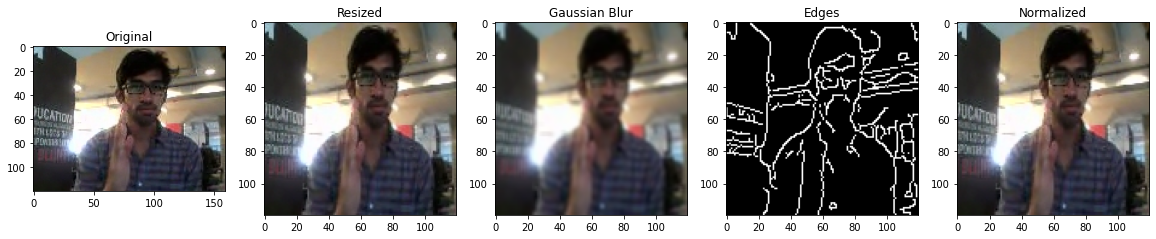

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


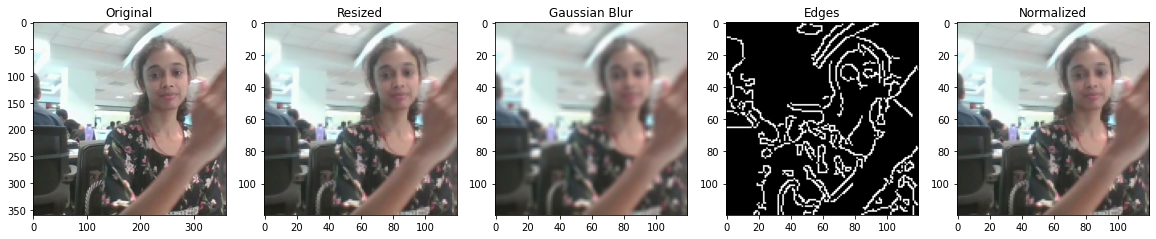

Image for Swipe Right:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


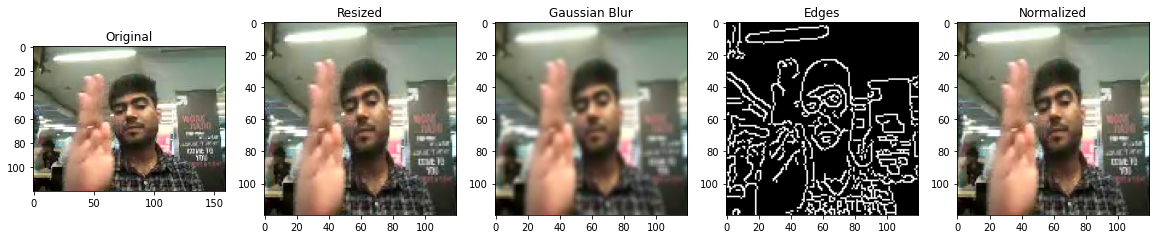

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


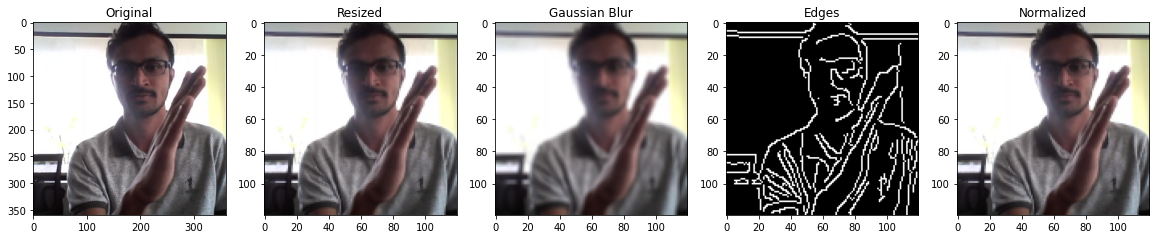

Image for Stop:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


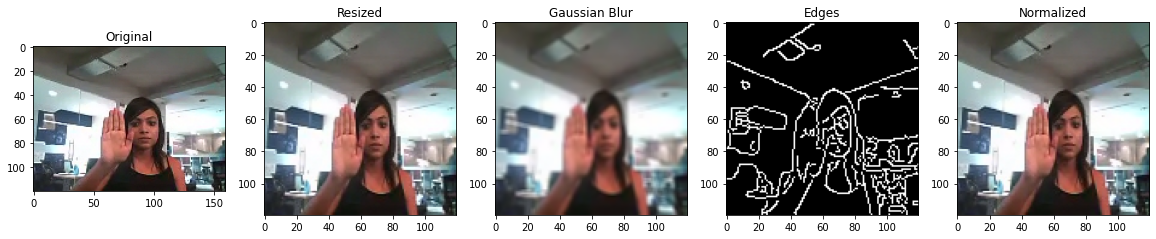

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


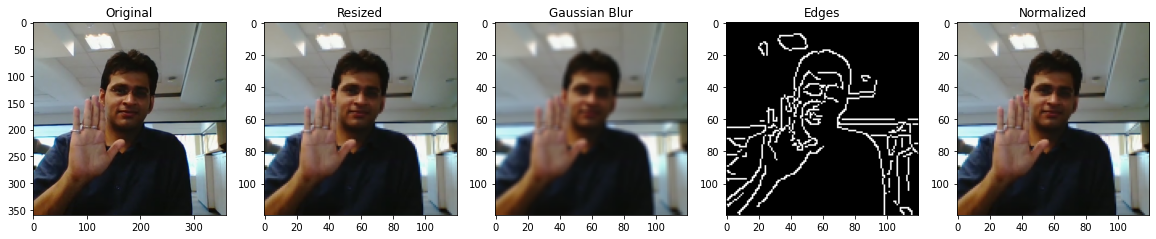

Image for Volume Down:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


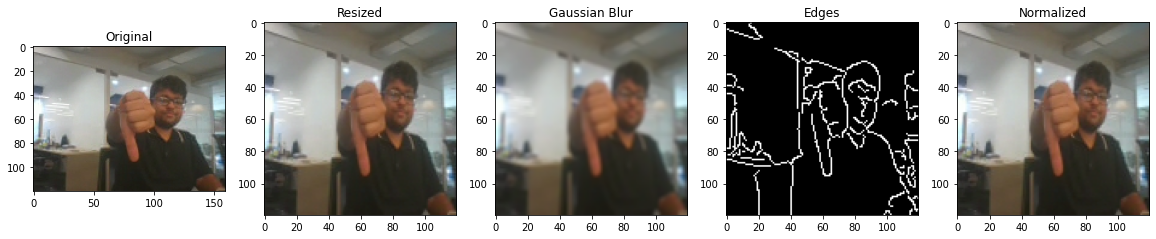

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


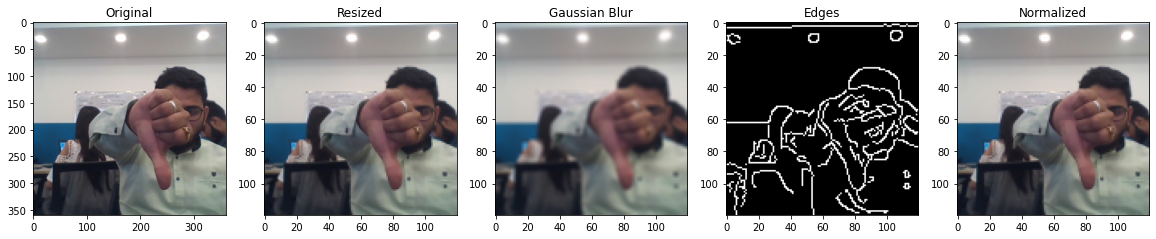

Image for Volume Up:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


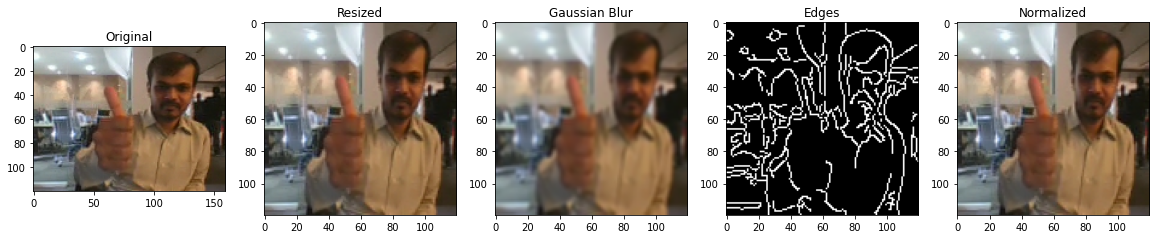

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


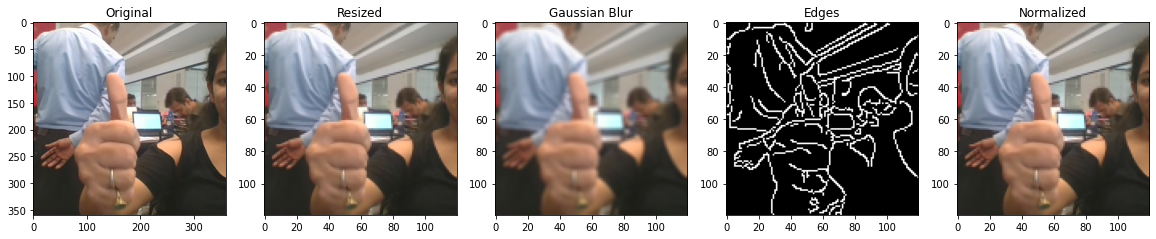

In [12]:
# View the images with their augmented outputs
print('\033[1m' + 'Image for Swipe Left:' + '\033[0m')
imageview(class_0_120, '/datasets/Project_data/train')
imageview(class_0_360, '/datasets/Project_data/train')
print('\033[1m' + 'Image for Swipe Right:' + '\033[0m')
imageview(class_1_120, '/datasets/Project_data/train')
imageview(class_1_360, '/datasets/Project_data/train')
print('\033[1m' + 'Image for Stop:' + '\033[0m')
imageview(class_2_120, '/datasets/Project_data/train')
imageview(class_2_360, '/datasets/Project_data/train')
print('\033[1m' + 'Image for Volume Down:' + '\033[0m')
imageview(class_3_120, '/datasets/Project_data/train')
imageview(class_3_360, '/datasets/Project_data/train')
print('\033[1m' + 'Image for Volume Up:' + '\033[0m')
imageview(class_4_120, '/datasets/Project_data/train')
imageview(class_4_360, '/datasets/Project_data/train')

### <font color="purple">Step 2: Generator Implementation</font>

##### <font color="purple">Creates batches of video data for neural network training.
- Handles video data with a specific directory structure.
- Includes Gaussian-blurred image augmentation for training.
- Experiment with different parameters (batch size, dimensions) for optimal training.

##### <font color="purple"> Parameters:
- `source_path`: Directory path for video data.
- `folder_list`: List of video folders.
- `batch_size`: Number of video sequences per iteration.
- `num_frames`: Number of frames per video.
- `frame_height`, `frame_width`: Desired frame dimensions.
- `augment`: Enable/disable data augmentation (default: False).
- `normalize`: Enable/disable pixel value normalization (default: False).

##### <font color="purple"> Function Overview:
- Image Indexing: Generates indices based on frame count.
- Data Generation Loop: Generates data batches indefinitely.
- Batch Processing: Loads, resizes, augments, and encodes data.
- Data Yielding: Yields data and labels for model training.
- Handling Remaining Data: Processes leftover data points.</font>


In [13]:
# The generator function
def generator(source_path, folder_list, batch_size, num_frames, frame_height, frame_width, augment, normalize):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # Based on the number of frames, some frames can be skipped in between. Use linspace function to do that
    img_idx = np.round(np.linspace(0, 29, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video
    print("Image Indexes: ", img_idx)
    while True:
        t           = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size) # calculate the number of batches
        for batch in range(num_batches):      # we iterate over the number of batches
            
            batch_data      = np.zeros((batch_size, num_frames, frame_height, frame_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels    = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_blur = np.zeros((batch_size, num_frames, frame_height, frame_width, 3))
            batch_data_edge = np.zeros((batch_size, num_frames, frame_height, frame_width, 3))           
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Resize the Images maintaining the aspect ratio
                    image_resized = cv2.resize(image, (frame_height,frame_width), interpolation = cv2.INTER_AREA)
                    
                    if(normalize == True):
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255.0 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255.0 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255.0 #normalise and feed in the image       
                    else:
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image                          
                    
                    # Add augmentation (Gaussian Noise Images)
                    if (augment == True):                
                        # Add blurred images
                        image_blur = cv2.GaussianBlur(image_resized,(3,3),3)
                        if(normalize == True):
                            batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0])/255 #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1])/255 #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2])/255 #normalise and feed in the image
                        else:
                            batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0]) #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1]) #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2]) #normalise and feed in the image                          
                  
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if(augment == True):
                # Add blurred images to the data
                batch_data    = np.concatenate([batch_data, batch_data_blur])
                batch_labels  = np.concatenate([batch_labels, batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        remaining_data = len(t) % batch_size
        if(remaining_data != 0):
            
            batch_data = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels    = np.zeros((remaining_data,5))                                    # batch_labels is the one hot representation of the output
            batch_data_blur = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3))
            batch_data_edge = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3))           

            for folder in range(remaining_data): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Resize the Images maintaining the aspect ratio
                    image_resized = cv2.resize(image, (frame_height,frame_width), interpolation = cv2.INTER_AREA)
                    
                    if(normalize == True):
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255.0 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255.0 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255.0 #normalise and feed in the image       
                    else:
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image     
                    
                    # Add augmentation (Gaussian Noise Images)
                    if(augment == True):
                        # Add blurred images
                        image_blur = cv2.GaussianBlur(image_resized,(3,3),3)

                        if(normalize == True):
                            batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0])/255 #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1])/255 #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2])/255 #normalise and feed in the image
                        else:
                            batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0]) #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1]) #normalise and feed in the image
                            batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2]) #normalise and feed in the image    

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            if(augment == True):
                # Add blurred images to the data
                batch_data = np.concatenate([batch_data, batch_data_blur])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            yield batch_data, batch_labels 

####  <font color="purple">Step3:  Test the Generator Function on Training data set</font>

<font color="purple">- Below code tests the functionality of the previously defined generator function on the training dataset. This involves creating batches of video data and examining their shapes.</font>

#####  <font color="purple">Testing Parameters:</font>
- <font color="purple"> num_frames: Integer, the number of frames to be considered for each video.</font>
- <font color="purple"> frame_height: Integer, the desired height of each frame.</font>
- <font color="purple"> frame_width: Integer, the desired width of each frame.</font>
- <font color="purple"> augment: Boolean, indicating whether data augmentation should be applied (set to False for this test).</font>
- <font color="purple"> normalize: Boolean, indicating whether pixel values should be normalized to the range [0, 1].</font>


In [14]:
# Test the Generator function on training data set

num_frames    = 20 
frame_height  = 120
frame_width   = 120
augment       = False
normalize     = True

train_generator = generator(train_path, train_doc, batch_size, num_frames, frame_height, frame_width, augment, normalize)

for i in range(int(len(train_doc)//batch_size + 1)):
    batch_data_temp, batch_label_temp = next(train_generator)
    print('Shape of each batch: ',batch_data_temp.shape)
    print('Shape of each batch label: ',batch_label_temp.shape)      

Source path =  /datasets/Project_data/train ; batch size = 32
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each batch label:  (32, 5)
Shape of each batch:  (32, 20, 120, 120, 3)
Shape of each ba

##### <font color="purple">Step3: Test the Generator Function on Validation data set</font>
- <font color="purple">Below code tests the functionality of the previously defined generator function on the validation dataset. This involves creating batches of video data and examining their shapes.</font>

##### <font color="purple">Testing Parameters:</font>
- <font color="purple">num_frames: Integer, the number of frames to be considered for each video.</font>
- <font color="purple">frame_height: Integer, the desired height of each frame.</font>
- <font color="purple">frame_width: Integer, the desired width of each frame.</font>
- <font color="purple">augment: Boolean, indicating whether data augmentation should be applied (set to False for this test).</font>
- <font color="purple">normalize: Boolean, indicating whether pixel values should be normalized to the range [0, 1].</font>


In [ ]:
# Test the Generator function on validation data set

num_frames    = 20
frame_height  = 120
frame_width   = 120
augment       = False
normalize     = True

val_generator = generator(val_path, val_doc, batch_size, num_frames, frame_height, frame_width, augment, normalize)

if (len(val_doc)%batch_size) == 0:
    for i in range(int(len(val_doc)/batch_size)):
        batch_data_temp, batch_label_temp = next(val_generator)
        print('Shape of each batch: ',batch_data_temp.shape)
        print('Shape of each batch label: ',batch_label_temp.shape)        
else:
    for i in range(int(len(val_doc)//batch_size + 1)):
        batch_data_temp, batch_label_temp = next(val_generator)
        print('Shape of each batch: ',batch_data_temp.shape)
        print('Shape of each batch label: ',batch_label_temp.shape)  

In [16]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


##  <font color="purple"> Implementation of Various Model(s):</font>

#### <font color="purple"> Step 4: Designing the Conv3D Model Architecture</font>

- <font color="purple">This section outlines the considerations and steps involved in constructing a Conv3D neural network model using Keras, emphasizing accuracy optimization while minimizing parameter count. The aim is to craft a model suitable for tasks dealing with video data, such as gesture recognition.</font>

####  <font color="purple">Usage of Conv3D and MaxPooling3D:</font>

####  <font color="purple">Convolution Layer Selection:</font>
- <font color="purple">Implement Conv3D layers for 3D convolutions on video data, crucial for capturing spatiotemporal features within video sequences.</font>

####  <font color="purple">Pooling Operations:</font>
- <font color="purple">Incorporate MaxPooling3D layers to down-sample spatial dimensions, aiding computational efficiency while preserving essential information.</font>

####  <font color="purple">TimeDistributed for Conv2D + RNN Model:</font>

<font color="purple">- TimeDistributed Layer:</font>
  - <font color="purple">When combining Conv2D with Recurrent Neural Networks (RNN), utilize TimeDistributed layers for applying 2D convolutions across temporal slices, essential for effective video sequence handling.</font>

####  <font color="purple">Softmax Output Layer:</font>

<font color="purple">- Output Layer:</font>
  - <font color="purple">The final network layer should be a softmax layer, commonly used for classification tasks to produce probability distributions over classes.</font>

####  <font color="purple">Optimization for Memory Constraints:</font>

<font color="purple">- Parameter Efficiency:</font>
  - <font color="purple">Optimize the model to achieve high accuracy with minimal parameters, crucial for memory-constrained scenarios such as fitting the model into webcam or resource-limited devices.</font>


###  <font color="purple">User-defined Custom Functions:</font>

<font color="purple">Let's define a set of custom functions that are essential for the training and evaluation of the model:</font>

1. <font color="purple">**generator()**</font>
<font color="purple">The generator() function is assumed to be already implemented and is responsible for creating a data generator, which efficiently loads batches for model training.</font>

2. <font color="purple">**trainer()**</font>
<font color="purple">The trainer() function trains the specified neural network model using training and validation data generators. It computes and returns the accuracy and loss values throughout the training process.</font>

3. <font color="purple">**modelplot(history)**</font>
<font color="purple">The modelplot() function plots the accuracy and loss curves based on the training history obtained during the training process.</font>


In [17]:
# Function to fit and train the Model
def trainer(model, model_name, num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize):
    #normalize = normalize
    # Model with the training data
    train_gen = generator(train_path, train_doc, size_batch, num_frames, frame_height, frame_width, augment, normalize)
    # Calculate steps per epoch
    if (len(train_doc)%size_batch) == 0:
        train_steps_per_epoch = int(len(train_doc)/size_batch)
    else:
        train_steps_per_epoch = (len(train_doc)//size_batch) + 1

    # Model with validation data (Augmentation is not applied on the validation data set)
    augment = False
    val_gen = generator(val_path, val_doc, size_batch, num_frames, frame_height, frame_width, augment, normalize)
    # Calculate steps per epoch
    if (len(val_doc)%size_batch) == 0:
        val_steps_per_epoch = int(len(val_doc)/size_batch)
    else:
        val_steps_per_epoch = (len(val_doc)//size_batch) + 1

    # Callback function to save models   
    curr_dt_time = datetime.datetime.now() # Current date and time to store the models with timestamp
    mod_name = model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(mod_name):
        os.mkdir(mod_name)        
    filepath = mod_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)        
        
    # Callback function to reduce learning rate upon reaching a plateau
    LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 4, verbose = 1) # write the REducelronplateau code here
    
    # Early Stop callback function
    earlystop = EarlyStopping(monitor = "val_loss", mode='auto', patience = 10, verbose = 1)
    
    # List of all callback functions
    callbacks_list = [checkpoint, LR, earlystop]

    # Fit the model
    history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch, 
                                      epochs = num_epochs, verbose = 1,
                                      callbacks = callbacks_list, workers = 1, 
                                      initial_epoch = 0, class_weight = None,
                                      validation_data = val_gen, 
                                      validation_steps = val_steps_per_epoch,
                                      shuffle=False)                                        
  
    return history_obj

In [18]:
# Custom function for plotting accuracies and losses of the model
def modelplot(history):
    
    fig = plt.figure(figsize = (16, 5))
    
    # Plot the loss
    plt.subplot(121)
    plt.title('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train_loss','val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Plot the accuracy
    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.legend(['train_categorical_accuracy','val_categorical_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.show()

###  <font color="purple">Sample Model to Test</font>
- <font color="purple">The Conv3D test model serves as an initial architecture for experimentation and evaluation.</font>
- <font color="purple">It is suitable for a test run to gauge its performance and make any necessary adjustments before more extensive training.</font>


In [19]:
# Test Conv3D Model for test run
def model_Conv3D_Test(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), 
                     input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3,3,3)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

#### <font color="purple">Deciding the batch size, image size, and number of frames</font>

- <font color="purple">Time taken and the memory needed to train the model is greatly affected by the batch size, image size, and number of frames. We do as below:</font>
  - <font color="purple">Experiment with different batch size till we hit the OOM error of GPU</font>
  - <font color="purple">Let us try three image sizes - 100x100, 120x120, and 160x160</font>
  - <font color="purple">Choose appropriate number of frames</font>

# <font color="purple">Observations:</font>
#### <font color="purple">Choosing Batch Size</font>
- <font color="purple">We choose the batch size as 32 and the number of frames as 24 to avoid OOM error</font>
- <font color="purple">However, depending on the model architecture we may change this if needed</font>


In [20]:
# Model with image size 100x100

num_frames    = 24
frame_height  = 100
frame_width   = 100
batch_size    = 32
num_epochs    = 2
augment       = False # Add Gaussian Blurring taken care in Generator function
normalize     = True  # Diving image channel wise by 255 taken care in Generator function

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
trainer(model, 'Conv3D_Test', num_epochs, batch_size, num_frames, frame_height, frame_width, augment, normalize)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 24, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 24, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 24, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 33, 33, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 33, 33, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 33, 33, 32)     0

2023-12-24 11:55:02.064417: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-12-24 11:55:02.064481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46480 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3d:00.0, compute capability: 8.6
/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Source path =  /datasets/Project_data/train ; batch size = 32
Image Indexes:  [ 0  1  3  4  5  6  8  9 10 11 13 14 15 16 18 19 20 21 23 24 25 26 28 29]
Epoch 1/2


2023-12-24 11:55:06.516948: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2023-12-24 11:55:08.288443: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


21/21 [==============================] - ETA: 0s - loss: 1.1992 - categorical_accuracy: 0.5882Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  1  3  4  5  6  8  9 10 11 13 14 15 16 18 19 20 21 23 24 25 26 28 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to Conv3D_Test_2023-12-2411_55_02.213554/model-00001-1.19922-0.58824-2.65234-0.16000.h5
21/21 [==============================] - 59s 3s/step - loss: 1.1992 - categorical_accuracy: 0.5882 - val_loss: 2.6523 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
21/21 [==============================] - ETA: 0s - loss: 0.5576 - categorical_accuracy: 0.7919
Epoch 00002: val_categorical_accuracy did not improve from 0.16000
21/21 [==============================] - 56s 3s/step - loss: 0.5576 - categorical_accuracy: 0.7919 - val_loss: 4.0618 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [21]:
# Model with image size 120x120
 
num_frames    = 24
frame_height  = 120
frame_width   = 120
size_batch    = 32
num_epochs    = 2
augment       = False
normalize     = True

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
trainer(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 24, 120, 120, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 24, 120, 120, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 24, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 40, 40, 32)     4128      
                                                                 
 activation_7 (Activation)   (None, 8, 40, 40, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/2
21/21 [==============================] - ETA: 0s - loss: 1.1880 - categorical_accuracy: 0.5641Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  1  3  4  5  6  8  9 10 11 13 14 15 16 18 19 20 21 23 24 25 26 28 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to Conv3D_Test_2023-12-2411_57_24.470507/model-00001-1.18800-0.56410-2.22265-0.16000.h5
21/21 [==============================] - 56s 3s/step - loss: 1.1880 - categorical_accuracy: 0.5641 - val_loss: 2.2227 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
21/21 [==============================] - ETA: 0s - loss: 0.4971 - categorical_accuracy: 0.8220
Epoch 00002: val_categorical_accuracy did not improve from 0.16000
21/21 [==============================] - 53s 3s/step - loss: 0.4971 - categorical_accuracy: 0.8220 - val_loss: 4.8651 - val_categorical_accuracy: 0.1200 - lr: 0.0010


In [22]:
# # Model with image size 160x160
 
num_frames    = 24
frame_height  = 160
frame_width   = 160
size_batch    = 32
num_epochs    = 2
augment       = False
normalize     = True  # Diving image channel wise by 255 taken care in Generator function

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# # Run the model and check accuracy
trainer(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 24, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 24, 160, 160, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 24, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 53, 53, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 53, 53, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 53, 53, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/2
21/21 [==============================] - ETA: 0s - loss: 1.2058 - categorical_accuracy: 0.5777Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  1  3  4  5  6  8  9 10 11 13 14 15 16 18 19 20 21 23 24 25 26 28 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to Conv3D_Test_2023-12-2411_59_37.053712/model-00001-1.20585-0.57768-2.72178-0.21000.h5
21/21 [==============================] - 65s 3s/step - loss: 1.2058 - categorical_accuracy: 0.5777 - val_loss: 2.7218 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
21/21 [==============================] - ETA: 0s - loss: 0.4035 - categorical_accuracy: 0.8537
Epoch 00002: val_categorical_accuracy did not improve from 0.21000
21/21 [==============================] - 62s 3s/step - loss: 0.4035 - categorical_accuracy: 0.8537 - val_loss: 6.5516 - val_categorical_accuracy: 0.1800 - lr: 0.0010


## <font color="purple">Observations:</font>

- <font color="purple">Image with size 160x160 may run into OOM error with higher frame count.</font>
- <font color="purple"> As it can be seen <strong>120x120 size</strong> seemed better as it takes lesser time and at the same time gives good accuracy.</font>
- <font color="purple">It is a good balance between time and accuracy.</font>
- <font color="purple">It also helps us to choose a higher batch size.</font>
- <font color="purple"> We will start with this batch size but we will check further on <strong>100x100 size</strong> as well in some models.</font>


####  <font color="purple">Choose number of frames</font>

- <font color="purple">We decided that just one image is sufficient to recognize gestures like Thumbs Up, Thumbs Down, or Stop. For Left and Right Swipes, at most, two images are needed. So, instead of using all 30 frames, we settled on using either 16 or 20 frames. </font>
- <font color="purple">    This not only helps in preventing overfitting but also ensures a more manageable and efficient approach.</font>

<font color="purple">As these parameters are decided let us start building the model and decide on other parameters such as filter size, layers etc</font>


## <font color="purple"> Model Architecture 1 - Conv3D model with filter size (3,3,3)</font>

- <font color="purple">'model_Conv3D_1' serves as a baseline Conv3D architecture for video classification tasks, particularly suited for recognizing gestures within video sequences.</font>
- <font color="purple">The model is designed to strike a balance between complexity and performance, and it can be further refined and customized based on specific requirements and experimentation.</font>

In [23]:
def model_Conv3D_1(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), 
                     input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_18 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_19 (Activation)  (None, 8, 60, 60, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.3812 - categorical_accuracy: 0.4600Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28000, saving model to Conv3D_1_2023-12-2412_03_08.799035/model-00001-1.38123-0.46003-1.75806-0.28000.h5
21/21 [==============================] - 38s 2s/step - loss: 1.3812 - categorical_accuracy: 0.4600 - val_loss: 1.7581 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.8645 - categorical_accuracy: 0.6727
Epoch 00002: val_categorical_accuracy did not improve from 0.28000
21/21 [==============================] - 36s 2s/step - loss: 0.8645 - categorical_accuracy: 0.6727 - val_loss: 3.9320 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.5611 - categorical_accurac

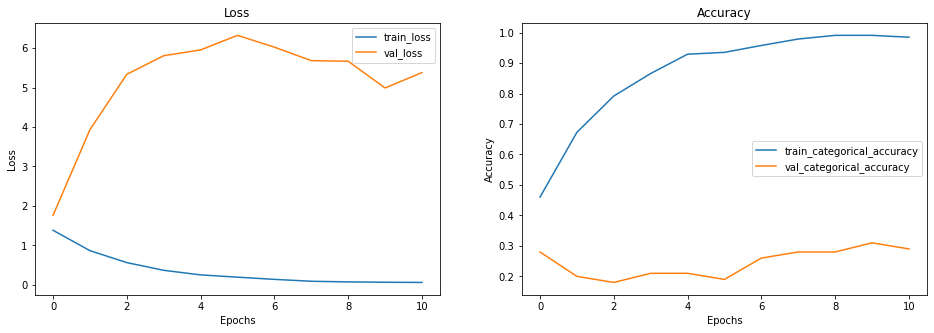

In [24]:
# Model 1 - Conv3D Model with filter size (3,3,3)

frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = False
normalize       = True

model = model_Conv3D_1(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)
modelplot(model_history)

## <font color="purple">Observations:</font>


<font color="purple">- As observed, there is a clear issue of <strong>`Overfitting`</strong> in Model 1. To address this concern, let's explore whether adjusting the kernel size to (2,2,2) can mitigate the overfitting problem.</font>

 
 

###  <font color="purple">Model Architecture 2 - Conv3D model with filter size (2,2,2)</font>

- <font color="purple">'model_Conv3D_2' serves as an experiment to address overfitting by adjusting the filter size in Conv3D layers. The effectiveness of this modification can be assessed through model training and evaluation, comparing its performance with the previous architecture. Further experimentation may be needed to fine-tune the model for optimal results.</font>


In [25]:
# Model 2 - Conv3D Model with filter size (2,2,2)
def model_Conv3D_2(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (2,2,2), 
                     input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_25 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_26 (Activation)  (None, 8, 60, 60, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.2512 - categorical_accuracy: 0.4947Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to Conv3D_2_2023-12-2412_11_33.763456/model-00001-1.25123-0.49472-2.23709-0.16000.h5
21/21 [==============================] - 38s 2s/step - loss: 1.2512 - categorical_accuracy: 0.4947 - val_loss: 2.2371 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.7417 - categorical_accuracy: 0.7044
Epoch 00002: val_categorical_accuracy did not improve from 0.16000
21/21 [==============================] - 36s 2s/step - loss: 0.7417 - categorical_accuracy: 0.7044 - val_loss: 3.8507 - val_categorical_accuracy: 0.1100 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.4264 - categorical_accurac

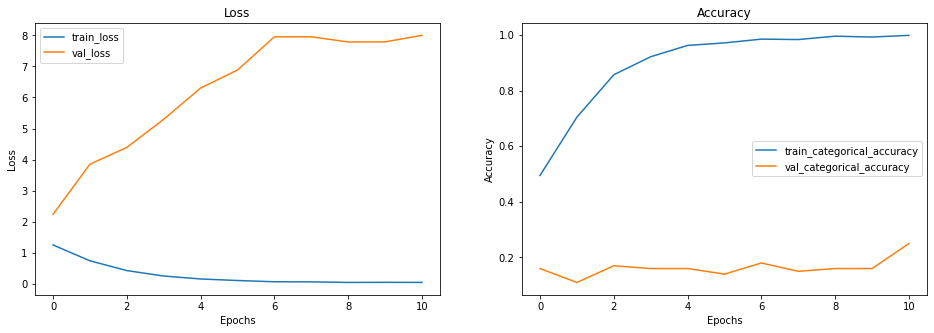

In [26]:
# Model 2 - Conv3D Model with filter size (2,2,2)

frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = False
normalization   = True

model = model_Conv3D_2(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_2', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

##  <font color="purple">Observation(s):</font>
- <font color="purple">As observed, there is a clear issue of <strong>`Overfitting`</strong> in Model 2. To address this concern, let's explore by applying toggle on Augmentation and Normalization.</font>


###  <font color="purple"> Model Architecture 3 - Conv3D model with filter size (3,3,3) and Augmentation</font>

- <font color="purple">'model_Conv3D_3' serves as an experiment to assess the impact of larger filter sizes in Conv3D layers on model performance, particularly in addressing overfitting. The model's effectiveness can be evaluated through training and testing, and further adjustments may be considered based on the observed outcomes.</font>


In [27]:
# Model 3 - Conv3D Model with filter size (3,3,3)
def model_Conv3D_3(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), 
                     input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_25 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_33 (Activation)  (None, 8, 60, 60, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4718 - categorical_accuracy: 0.3808Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31000, saving model to Conv3D_3_1_2023-12-2412_18_21.511981/model-00001-1.47184-0.38084-1.60518-0.31000.h5
21/21 [==============================] - 46s 2s/step - loss: 1.4718 - categorical_accuracy: 0.3808 - val_loss: 1.6052 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9909 - categorical_accuracy: 0.6018
Epoch 00002: val_categorical_accuracy did not improve from 0.31000
21/21 [==============================] - 43s 2s/step - loss: 0.9909 - categorical_accuracy: 0.6018 - val_loss: 2.2886 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.6921 - categorical_accur

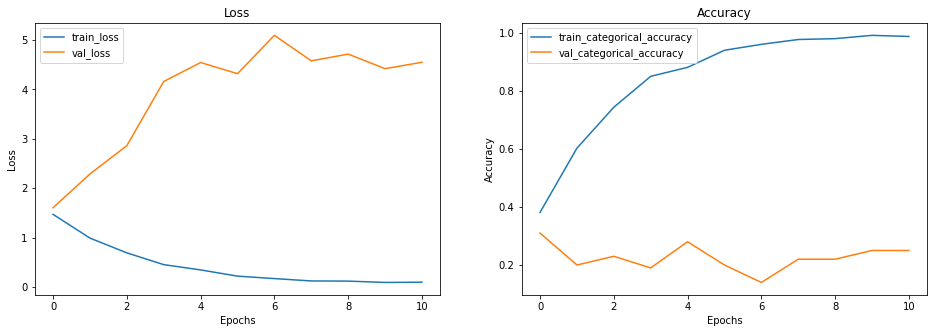

In [28]:
# Model 3 - Conv3D Model with filter size (3,3,3)

frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = True

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

##  <font color="purple">Observation(s):</font>

- <font color="purple">Above model overfits as well</font>


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_39 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_40 (Activation)  (None, 8, 60, 60, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5281 - categorical_accuracy: 0.3658Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to Conv3D_3_2_2023-12-2412_29_50.568682/model-00001-1.52813-0.36576-12.44401-0.23000.h5
21/21 [==============================] - 44s 2s/step - loss: 1.5281 - categorical_accuracy: 0.3658 - val_loss: 12.4440 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.1652 - categorical_accuracy: 0.5287
Epoch 00002: val_categorical_accuracy improved from 0.23000 to 0.24000, saving model to Conv3D_3_2_2023-12-2412_29_50.568682/model-00002-1.16519-0.52866-4.43189-0.24000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.1652 - categorical_accuracy: 0.5287 - val_loss: 4.4319 - val_categorical_accuracy: 0.2400 

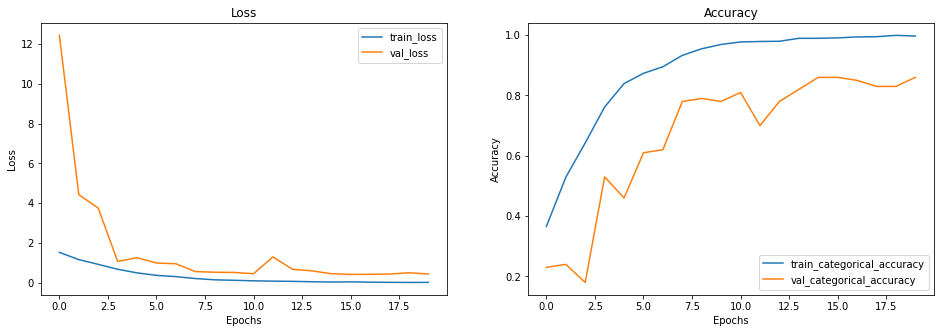

In [29]:
# Model 4 - Conv3D Model with filter size (3,3,3) without Normalization

frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_2', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

##  <font color="purple">Observation(s):</font>
- <font color="purple">Till now Model 4 - Conv3D Model with filter size (3,3,3) without Normalization with augmentation has performed the best till now with</font>
- <font color="purple">`97%` Train accuracy and</font>
- <font color="purple">`86%` Validation accuracy</font>
- <font color="purple">Adam Optimizer and 700k parameters</font>
- <font color="purple">Let's explore more if this can be further improved.</font>


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_46 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_35 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_47 (Activation)  (None, 8, 60, 60, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6946 - categorical_accuracy: 0.2964Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to Conv3D_3_3_2023-12-2412_44_18.358064/model-00001-1.69463-0.29638-3.39209-0.23000.h5
21/21 [==============================] - 44s 2s/step - loss: 1.6946 - categorical_accuracy: 0.2964 - val_loss: 3.3921 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3284 - categorical_accuracy: 0.4427
Epoch 00002: val_categorical_accuracy did not improve from 0.23000
21/21 [==============================] - 42s 2s/step - loss: 1.3284 - categorical_accuracy: 0.4427 - val_loss: 3.5605 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1318 - categorical_accur

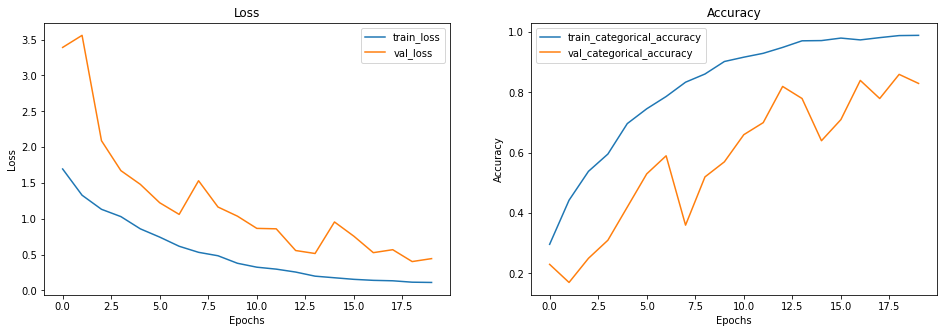

In [30]:
# Model 5 - Conv3D Model with filter size (3,3,3) 
# This model is same as above but with SGD Optimizer
frame_height    = 120
frame_width     = 120
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = 'sgd'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_3', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

#### Observation(s):
- categorical_accuracy: '98%' 
- val_categorical_accuracy: '86%'
- parameter size = 700k
- This model with SGD optimizer is almost similar to the previous model with Adam optimizer

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_53 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_40 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_54 (Activation)  (None, 8, 50, 50, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5569 - categorical_accuracy: 0.3499Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to Conv3D_3_4_2023-12-2412_59_24.585915/model-00001-1.55691-0.34992-17.63941-0.23000.h5
21/21 [==============================] - 44s 2s/step - loss: 1.5569 - categorical_accuracy: 0.3499 - val_loss: 17.6394 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2204 - categorical_accuracy: 0.5158
Epoch 00002: val_categorical_accuracy improved from 0.23000 to 0.27000, saving model to Conv3D_3_4_2023-12-2412_59_24.585915/model-00002-1.22038-0.51584-8.96806-0.27000.h5
21/21 [==============================] - 42s 2s/step - loss: 1.2204 - categorical_accuracy: 0.5158 - val_loss: 8.9681 - val_categorical_accuracy: 0.2700 

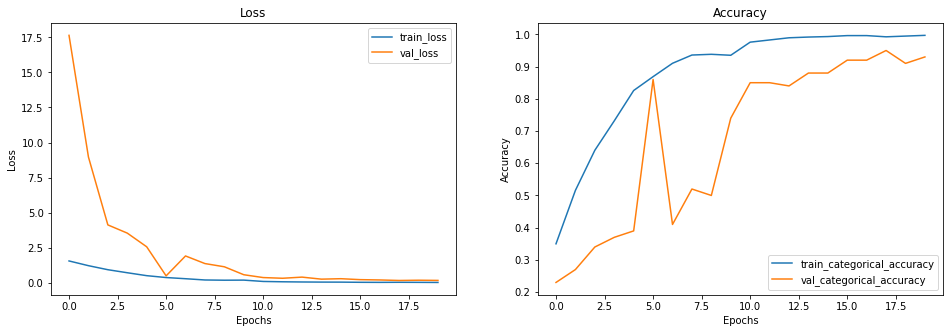

In [31]:
# Model 6 - Conv3D Model with filter size (3,3,3) with augmentation without Normalization and with Framesize 100x100

frame_height    = 100
frame_width     = 100
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_4', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

##  <font color="purple">Observation(s):</font>
- <font color="purple">categorical_accuracy: 0.99</font>
- <font color="purple">val_categorical_accuracy: 0.95</font>
- <font color="purple">parameter size = 600k</font>
- <font color="purple">Frame size used 100x100</font>


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_45 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_61 (Activation)  (None, 8, 50, 50, 32)    

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6952 - categorical_accuracy: 0.2941Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to Conv3D_3_5_2023-12-2413_13_42.825910/model-00001-1.69517-0.29412-4.41822-0.23000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.6952 - categorical_accuracy: 0.2941 - val_loss: 4.4182 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3067 - categorical_accuracy: 0.4570
Epoch 00002: val_categorical_accuracy did not improve from 0.23000
21/21 [==============================] - 43s 2s/step - loss: 1.3067 - categorical_accuracy: 0.4570 - val_loss: 2.5291 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.0664 - categorical_accur

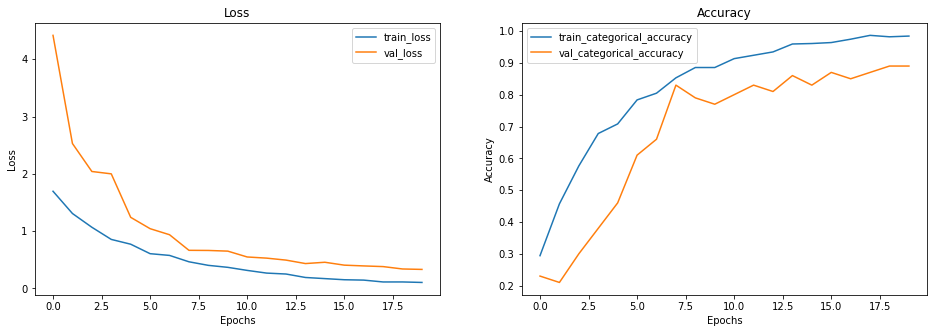

In [32]:
# Model 7 - Conv3D Model with filter size (3,3,3) with augmentation without Normalization and with Framesize 100x100 and SGD Optimizer

frame_height    = 100
frame_width     = 100
num_frames      = 16
size_batch      = 32
num_epochs      = 20
augment         = True
normalization   = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser = 'sgd'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_3_5', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

##  <font color="purple">Observation(s):</font>
- <font color="purple">categorical_accuracy: 0.97</font>
- <font color="purple">val_categorical_accuracy: 0.89</font>
- <font color="purple">parameter size = 600k</font>
- <font color="purple">SGD Optimizer</font>


### <font color="purple">Model Architecture 4 - Conv3D model with filter size (3,3,3) and 4 Conv3D layers and two Dense layers</font>


In [33]:
# Model Architecture 4 - Conv3D Model with filter size (3,3,3)
# Conv3D Filters 8, 16, 32, 64 followed by Dense layers in descending order of 512, 64 and finally 5
# Batch Normalization and Dropouts are also used
def model_Conv3D_4(num_frames, frame_height, frame_width):

    # Define model
    model = Sequential()

    model.add(Conv3D(8, 
                    kernel_size=(3,3,3), 
                    input_shape=(num_frames, frame_height, frame_width,3),
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(16, 
                    kernel_size=(3,3,3), 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32, 
                    kernel_size=(1,3,3), 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(64, 
                    kernel_size=(1,3,3), 
                    padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    #softmax layer
    model.add(Dense(5, activation='softmax'))

    return model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 20, 120, 120, 8)   656       
                                                                 
 batch_normalization_50 (Bat  (None, 20, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_67 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 10, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 10, 60, 60, 16)    3472      
                                                                 
 batch_normalization_51 (Bat  (None, 10, 60, 60, 16) 

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.1954 - categorical_accuracy: 0.2368Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18000, saving model to Conv3D_4_1_2023-12-2413_29_56.831314/model-00001-2.19539-0.23680-2.14857-0.18000.h5
21/21 [==============================] - 45s 2s/step - loss: 2.1954 - categorical_accuracy: 0.2368 - val_loss: 2.1486 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5232 - categorical_accuracy: 0.3122
Epoch 00002: val_categorical_accuracy improved from 0.18000 to 0.19000, saving model to Conv3D_4_1_2023-12-2413_29_56.831314/model-00002-1.52321-0.31222-3.48230-0.19000.h5
21/21 [==============================] - 44s 2s/step - loss: 1.5232 - categorical_accuracy: 0.3122 - val_loss: 3.4823 - val_categorical_accurac

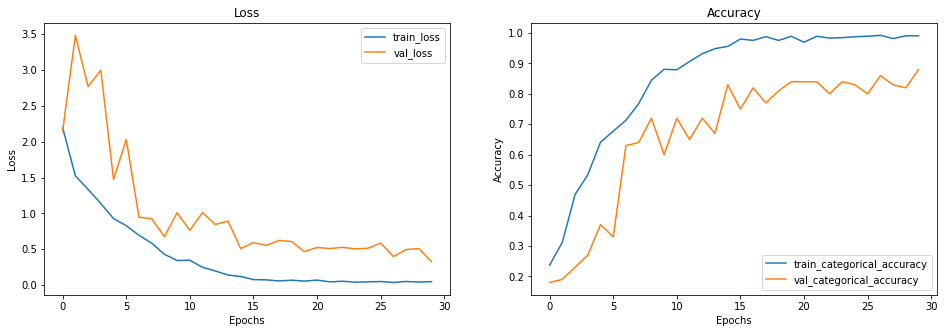

In [34]:
# Model 8 - Conv3D Model with filter size (3,3,3) with augmentation without Normalization and with Framesize 120X120

frame_height    = 120
frame_width     = 120
num_frames      = 20
size_batch      = 32
num_epochs      = 30
augment         = False
normalization   = False

model = model_Conv3D_4(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_4_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalization)
modelplot(model_history)

##  <font color="purple">Observation(s):</font>
 
- <font color="purple"> So far this is the best fit model in Conv3D Architecture</font>
- <font color="purple">Train accuracy is 99%</font>
- <font color="purple"> Validation accuracy is 88%</font>
- <font color="purple"> Parameter count 1.6M</font>


### <font color="purple"> Model Architecture 5 -  Conv3D model with filter size (3,3,3) and Leaky ReLU</font>

- <font color="purple">Let us improve upon the Conv3D model of filter size (3,3,3) with a slightly changed architecture and a Dense layer of 512</font>


In [35]:
# Conv3D Model with filter size (3,3,3)
def model_Conv3D_5(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(32,(3,3,3), strides=(1,1,1), 
              input_shape = (num_frames, frame_height, frame_width, 3),
              padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling3D(pool_size=(2,2,1),strides=(2,2,1)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv3D(64, (3,3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25)) # Dropout 0.5

    model.add(Flatten())
    model.add(Dropout(0.25)) # Dropout 0.25
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
# Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    return model


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 15, 100, 100, 32)  2624      
                                                                 
 batch_normalization_53 (Bat  (None, 15, 100, 100, 32)  128      
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 15, 100, 100, 32)  0         
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 7, 50, 100, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 7, 50, 100, 64)    55360     
                                                                 
 batch_normalization_54 (Bat  (None, 7, 50, 100, 64) 

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 155.9311 - categorical_accuracy: 0.2753Source path =  /datasets/Project_data/val ; batch size = 32
Image Indexes:  [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to Conv3D_5_1_2023-12-2413_52_38.030905/model-00001-155.93106-0.27526-289.89395-0.21000.h5
21/21 [==============================] - 45s 2s/step - loss: 155.9311 - categorical_accuracy: 0.2753 - val_loss: 289.8940 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 9.5504 - categorical_accuracy: 0.5008
Epoch 00002: val_categorical_accuracy did not improve from 0.21000
21/21 [==============================] - 39s 2s/step - loss: 9.5504 - categorical_accuracy: 0.5008 - val_loss: 118.5180 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 5.1019 - categori

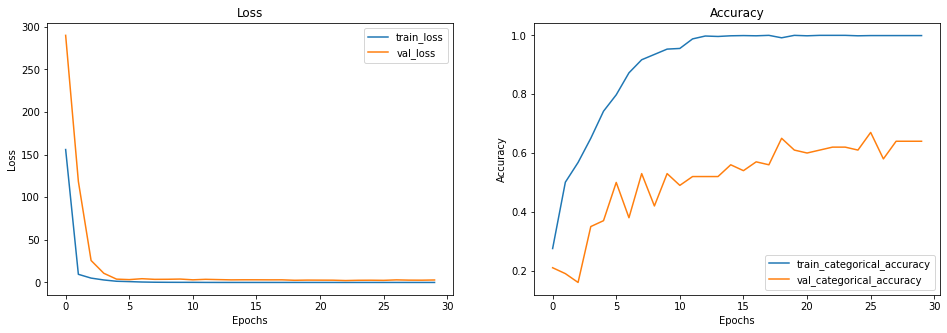

In [36]:
# Model 9 - Conv3D Model with filter size (3,3,3)
frame_height    = 100
frame_width     = 100
num_frames      = 15
size_batch      = 32
num_epochs      = 30
augment         = True
normalize       = True


model = model_Conv3D_5(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_5_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)
modelplot(model_history)

##  <font color="purple">Observation(s):</font>

- <font color="purple">The above model is overfitting</font>
- <font color="purple">Parameter count is very high ~77M</font>


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_47 (Conv3D)          (None, 15, 100, 100, 32)  2624      
                                                                 
 batch_normalization_56 (Bat  (None, 15, 100, 100, 32)  128      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 15, 100, 100, 32)  0         
                                                                 
 max_pooling3d_46 (MaxPoolin  (None, 7, 50, 100, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_48 (Conv3D)          (None, 7, 50, 100, 64)    55360     
                                                                 
 batch_normalization_57 (Bat  (None, 7, 50, 100, 64) 

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 10.5728 - categorical_accuracy: 0.3303Source path =  /datasets/Project_data/val ; batch size = 20
Image Indexes:  [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22000, saving model to Conv3D_5_2_2023-12-2414_14_20.127707/model-00001-10.57276-0.33032-8.51387-0.22000.h5
34/34 [==============================] - 37s 1s/step - loss: 10.5728 - categorical_accuracy: 0.3303 - val_loss: 8.5139 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2993 - categorical_accuracy: 0.5038
Epoch 00002: val_categorical_accuracy improved from 0.22000 to 0.29000, saving model to Conv3D_5_2_2023-12-2414_14_20.127707/model-00002-1.29926-0.50377-2.21353-0.29000.h5
34/34 [==============================] - 35s 1s/step - loss: 1.2993 - categorical_accuracy: 0.5038 - val_loss: 2.2135 - val_categorical_accuracy: 0.2900 - 

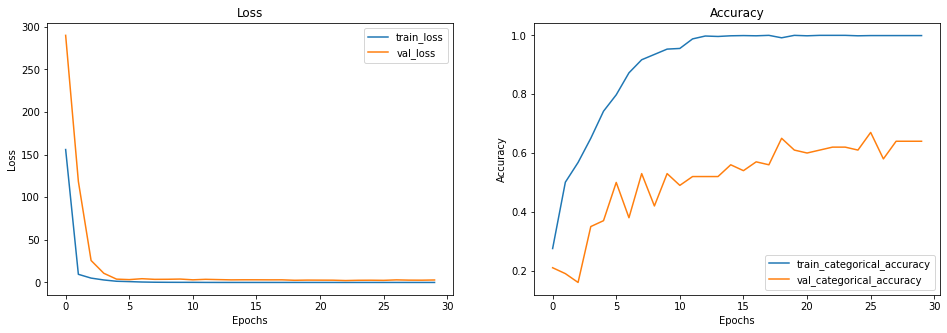

In [37]:
# Model 10 - Conv3D Model with filter size (3,3,3)
# Same as above model without augmentation
# Optimizer - SGD
frame_height    = 100
frame_width     = 100
num_frames      = 15
size_batch      = 20
num_epochs      = 30
augment         = False
normalize       = True

model = model_Conv3D_5(num_frames, frame_height, frame_width)
optimiser = 'sgd'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
pmodel_history = trainer(model, 'Conv3D_5_2', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)
modelplot(model_history)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_50 (Conv3D)          (None, 15, 100, 100, 32)  2624      
                                                                 
 batch_normalization_59 (Bat  (None, 15, 100, 100, 32)  128      
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 15, 100, 100, 32)  0         
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 7, 50, 100, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_51 (Conv3D)          (None, 7, 50, 100, 64)    55360     
                                                                 
 batch_normalization_60 (Bat  (None, 7, 50, 100, 64) 

/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 10.7659 - categorical_accuracy: 0.3077Source path =  /datasets/Project_data/val ; batch size = 20
Image Indexes:  [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to Conv3D_5_2_SGD_2023-12-2414_32_38.033299/model-00001-10.76590-0.30769-20.17977-0.23000.h5
34/34 [==============================] - 36s 1s/step - loss: 10.7659 - categorical_accuracy: 0.3077 - val_loss: 20.1798 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/30
33/34 [============================>.] - ETA: 0s - loss: 1.7791 - categorical_accuracy: 0.4273
Epoch 00002: val_categorical_accuracy improved from 0.23000 to 0.24000, saving model to Conv3D_5_2_SGD_2023-12-2414_32_38.033299/model-00002-1.77657-0.42836-15.03121-0.24000.h5
34/34 [==============================] - 34s 1s/step - loss: 1.7766 - categorical_accuracy: 0.4284 - val_loss: 15.0312 - val_categorical_accurac

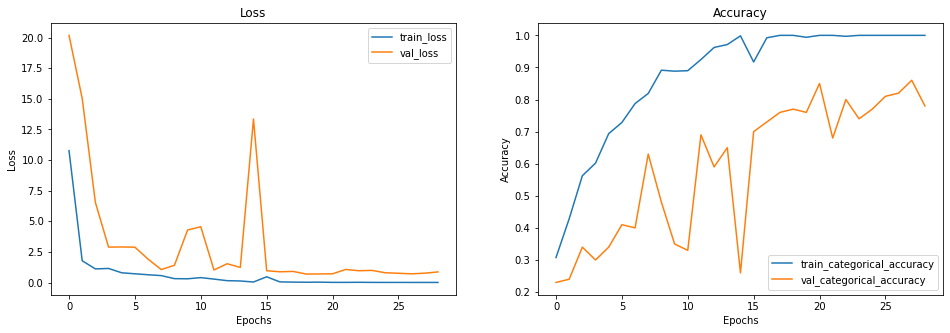

In [38]:
# Model 11 - Conv3D Model with filter size (3,3,3)
# Same as above model without augmentation or normalization
# Optimizer - SGD
frame_height    = 100
frame_width     = 100
num_frames      = 15
size_batch      = 20
num_epochs      = 30
augment         = False
normalize       = False

model = model_Conv3D_5(num_frames, frame_height, frame_width)
optimiser = 'sgd'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = trainer(model, 'Conv3D_5_2_SGD', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)
modelplot(model_history)

##  <font color="purple">Observation(s):</font>

- <font color="purple">There is no significant improvement in the above model architecture</font>


### <font color="purple"> Model Architecture 6 - CNN LSTM Model</font>

- <font color="purple">Now let us create an LSTM model</font>
- <font color="purple">Note that, so far for all the Conv3D models, we have used Relu as the activation function</font>
- <font color="purple">But for LSTM models, we will use tanh as the activation function.</font>
- <font color="purple">Given that ReLUs can have quite large outputs, they have traditionally been regarded as inappropriate for use with LSTMs</font>


In [75]:
# CNN LSTM Model
def model_LSTM_1(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'), input_shape = (num_frames, frame_height, frame_width, 3)))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.35))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.35))    

    # model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
    # model.add(Activation('relu'))
    # model.add(TimeDistributed(BatchNormalization()))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))    
    # model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.25))
    model.add(Dropout(0.25))
 
    model.add(LSTM(units=50, activation='tanh', recurrent_dropout=0.25))
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [78]:
# Model 12 - CNN LSTM Model

num_frames    = 20
frame_height  = 120
frame_width   = 120
size_batch    = 20
num_epochs    = 100
augment       = False
normalize     = False

model = model_LSTM_1(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_60 (TimeDi  (None, 20, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 activation_89 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 time_distributed_61 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 20, 60, 60, 32)   2080      
 stributed)                                          

In [79]:
model_history = trainer(model, 'model_LSTM_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

34/34 [==============================] - ETA: 0s - loss: 1.3835 - categorical_accuracy: 0.3635Source path =  /datasets/Project_data/val ; batch size = 20
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22000, saving model to model_LSTM_1_2023-12-2417_54_00.248070/model-00001-1.38352-0.36350-1.93271-0.22000.h5
34/34 [==============================] - 54s 1s/step - loss: 1.3835 - categorical_accuracy: 0.3635 - val_loss: 1.9327 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 1.1871 - categorical_accuracy: 0.5023
Epoch 00002: val_categorical_accuracy improved from 0.22000 to 0.29000, saving model to model_LSTM_1_2023-12-2417_54_00.248070/model-00002-1.18711-0.50226-1.84032-0.29000.h5
34/34 [==============================] - 46s 1s/step - loss: 1.1871 - categorical_accuracy: 0.5023 - val_loss: 1.8403 - val_categorical_accuracy: 0.2

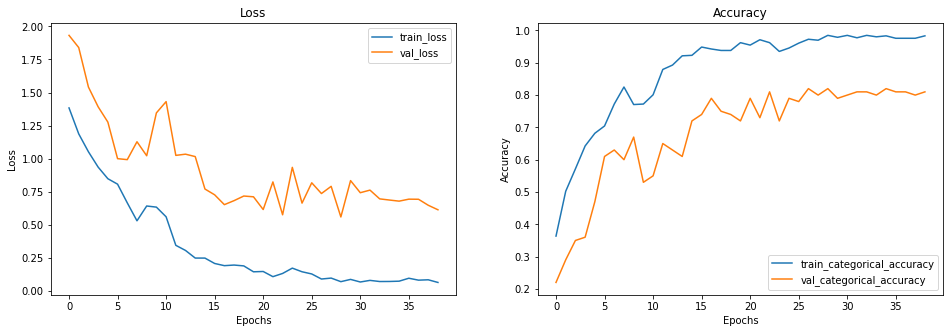

In [80]:
modelplot(model_history)

##  <font color="purple">Observation(s):</font>

- <font color="purple">The LSTM model performed with train accuracy if 97% and validation accuracy of 82%</font>

###  <font color="purple">Model Architecture 7 - CNN+GRU Model</font>

- <font color="purple">Let us try GRU instead of LSTM and see its performance</font>


In [43]:
# CNN GRU Model
def model_GRU_1(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'), input_shape = (num_frames, frame_height, frame_width, 3)))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))    
   
    model.add(TimeDistributed(Flatten()))
    
    model.add(GRU(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.25))
    model.add(Dropout(0.35))
 
    model.add(GRU(units=128, activation='tanh', recurrent_dropout=0.25))
    model.add(Dropout(0.5))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [44]:
# Model 13 - CNN GRU Model

num_frames    = 16
frame_height  = 120
frame_width   = 120
size_batch    = 50
num_epochs    = 100
augment       = False
normalize     = False

model = model_GRU_1(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 16, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 activation_79 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 60, 60, 32)   2080      
 stributed)                                          

In [45]:
# Run the model and check accuracy
model_history = trainer(model, 'model_GRU_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Source path =  /datasets/Project_data/train ; batch size = 50
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]


/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.5202 - categorical_accuracy: 0.3605Source path =  /datasets/Project_data/val ; batch size = 50
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to model_GRU_1_2023-12-2415_24_55.730144/model-00001-1.52024-0.36048-3.16968-0.23000.h5
14/14 [==============================] - 42s 3s/step - loss: 1.5202 - categorical_accuracy: 0.3605 - val_loss: 3.1697 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.2095 - categorical_accuracy: 0.4766
Epoch 00002: val_categorical_accuracy improved from 0.23000 to 0.25000, saving model to model_GRU_1_2023-12-2415_24_55.730144/model-00002-1.20946-0.47662-3.03471-0.25000.h5
14/14 [==============================] - 36s 3s/step - loss: 1.2095 - categorical_accuracy: 0.4766 - val_loss: 3.0347 - val_categorical_accuracy: 0.250

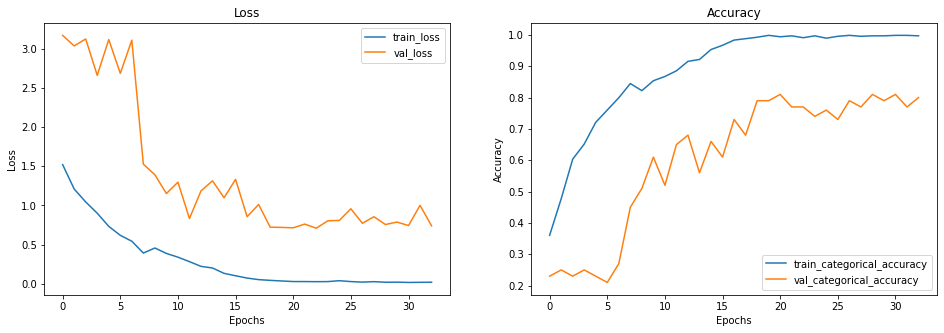

In [46]:
modelplot(model_history)

##  <font color="purple">Observation(s):</font>

- <font color="purple">Accuracy of GRU model is same as LSTM </font>
- <font color="purple">Train accuracy was 99% and validation accuracy is 81%</font>
- <font color="purple">Parameter size of 300k</font>


### <font color="purple"> Model Architecture 8 - Transfer Learning with MobileNet + GRU Model</font>

- <font color="purple">Let us try Transfer Learning with MobileNet and GRU and see its performance</font>


In [47]:
# MobileNet GRU Model

mobilenet_transfer = MobileNet(weights='imagenet', include_top=False)

def model_mobilenet_1(num_frames, frame_height, frame_width):

    num_class = 5
    
    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_frames, frame_height, frame_width,3)))

    
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(units=64, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.25))
    
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(num_class, activation='softmax'))
    return model

17235968/17225924 [==============================] - 2s 0us/step


In [49]:
# Model 14 - MobileNet GRU

num_frames    = 20
frame_height  = 120
frame_width   = 120
size_batch    = 40
num_epochs    = 100
augment       = False
normalize     = True

model = model_mobilenet_1(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)              

In [50]:
# Run the model and check accuracy
model_history = trainer(model, 'model_mobilenet_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Source path =  /datasets/Project_data/train ; batch size = 40
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]


/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 1.4903 - categorical_accuracy: 0.3680Source path =  /datasets/Project_data/val ; batch size = 40
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.48000, saving model to model_mobilenet_1_2023-12-2415_48_21.583528/model-00001-1.49028-0.36802-1.41945-0.48000.h5
17/17 [==============================] - 53s 3s/step - loss: 1.4903 - categorical_accuracy: 0.3680 - val_loss: 1.4195 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.8889 - categorical_accuracy: 0.6712
Epoch 00002: val_categorical_accuracy improved from 0.48000 to 0.62000, saving model to model_mobilenet_1_2023-12-2415_48_21.583528/model-00002-0.88887-0.67119-0.96392-0.62000.h5
17/17 [==============================] - 46s 3s/step - loss: 0.8889 - categorical_accuracy: 0.6712 - val_loss: 0.9639 - val_cat

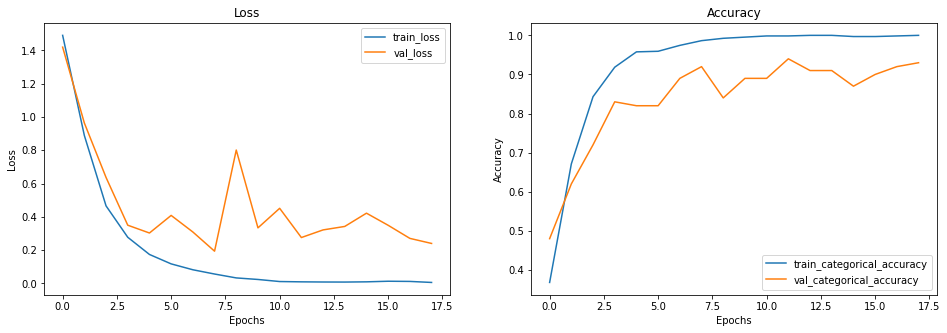

In [52]:
modelplot(model_history)

##  <font color="purple">Observation(s):</font>

- <font color="purple">Performance of this MobileNet+GRU Model is the best so far in terms of higher validation accuracy</font>
- <font color="purple">Train accuracy is 99% and validation accuracy is 94%</font>
- <font color="purple">Model parameters ~3M</font>



###  <font color="purple">Model Architecture 9 - VGG16 LSTM Model</font>

- <font color="purple">Now let us try the VGG16 model</font>


In [53]:
# VGG16 LSTM Model with GRU
def model_VGG16_TF_GRU(num_frames, frame_height, frame_width):

    num_class = 5
    
    def create_base():
        conv_base = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=(frame_height, frame_width, 3))
        count=0
        for layer in conv_base.layers:
            count = count+1
        print("num of layers in VGG16 " + str(count))
        # training the model after 140 layers
        split_at = 17
        for layer in conv_base.layers[:split_at]: layer.trainable = False
        for layer in conv_base.layers[split_at:]: layer.trainable = True
        x = GlobalAveragePooling2D()(conv_base.output)
        base_model = Model(conv_base.input, x)
        return base_model
    
    conv_base = create_base()
    
    ip = Input(shape=(num_frames, frame_height, frame_width, 3))
    t_conv = TimeDistributed(conv_base)(ip) 
    drop_l = Dropout(0.65)(t_conv)
    t_GRU_1 = GRU(units=128, return_sequences=True, activation='tanh', dropout=0.6, recurrent_dropout=0.6)(drop_l)
    
    t_GRU_2 = GRU(units=32, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(t_GRU_1)

    f_softmax = Dense(num_class, activation='softmax')(t_GRU_2)

    model = Model(ip, f_softmax)
    
    return model

In [54]:
# Model 15 - VGG16 transfer Learning Model with GRU

num_frames    = 18
frame_height  = 120
frame_width   = 120
size_batch    = 50
num_epochs    = 100
augment       = False
normalize     = True

model = model_VGG16_TF_GRU(num_frames, frame_height, frame_width)
optimiser = 'Adam'
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

58900480/58889256 [==============================] - 4s 0us/step
num of layers in VGG16 19
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 18, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_42 (TimeDi  (None, 18, 512)          14714688  
 stributed)                                                      
                                                                 
 dropout_40 (Dropout)        (None, 18, 512)           0         
                                                                 
 gru_4 (GRU)                 (None, 18, 128)           246528    
                                                                 
 gru_5 (GRU)                 (None, 32)                15552     
                                  

In [55]:
# Run the model and check accuracy
model_history = trainer(model, 'model_VGG16_TF_GRU', num_epochs, size_batch, num_frames, frame_height, frame_width, augment, normalize)

Source path =  /datasets/Project_data/train ; batch size = 50
Image Indexes:  [ 0  2  3  5  7  9 10 12 14 15 17 19 20 22 24 26 27 29]


/tmp/ipykernel_339/4129555906.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch,


Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.7008 - categorical_accuracy: 0.2172Source path =  /datasets/Project_data/val ; batch size = 50
Image Indexes:  [ 0  2  3  5  7  9 10 12 14 15 17 19 20 22 24 26 27 29]

Epoch 00001: val_categorical_accuracy improved from -inf to 0.29000, saving model to model_VGG16_TF_GRU_2023-12-2416_06_59.238566/model-00001-1.70081-0.21719-1.50844-0.29000.h5
14/14 [==============================] - 47s 3s/step - loss: 1.7008 - categorical_accuracy: 0.2172 - val_loss: 1.5084 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.6652 - categorical_accuracy: 0.2278
Epoch 00002: val_categorical_accuracy improved from 0.29000 to 0.33000, saving model to model_VGG16_TF_GRU_2023-12-2416_06_59.238566/model-00002-1.66525-0.22775-1.49920-0.33000.h5
14/14 [==============================] - 41s 3s/step - loss: 1.6652 - categorical_accuracy: 0.2278 - val_loss: 1.4992 - val_categor

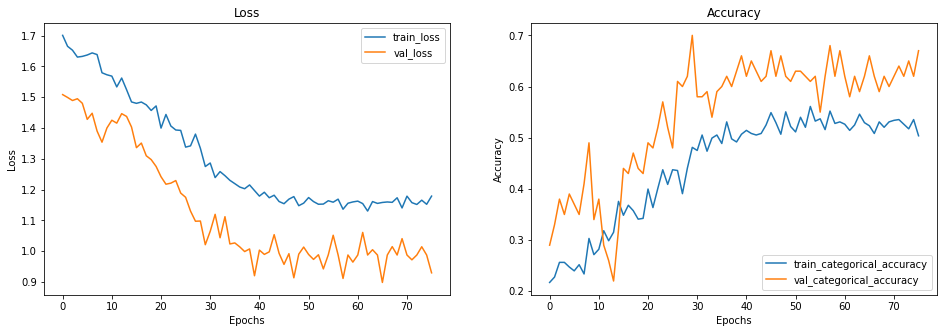

In [56]:
modelplot(model_history)

##  <font color="purple">Observation(s):</font>

- <font color="purple">Model is Clearly Underfitting </font>
- <font color="purple">Total number of parameters is very high and thus is not ideally suited</font>


# <font color="purple">Optimal Model #1: Transfer Learning Model - MobileNet + GRU Model(RNN)</font>


## <font color="purple">Load the Optimal model#1 and Test a sample</font>

- <font color="purple">Now that we have chosen one of the Optimal Model, let us load it once and use it to predict the class of one random image from the validation set to check if the .h5 file is created correctly and if the model works</font>


In [57]:
# Load the winner model i.e. MobileNet+GRU Model
model = load_model('model_mobilenet_1_2023-12-2415_48_21.583528/model-00012-0.00983-0.99849-0.27588-0.94000.h5')
#model_mobilenet_1_2023-12-2415_48_21.583528/model-00012-0.00983-0.99849-0.27588-0.94000.h5

In [58]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)              

In [59]:
# Test the model using one random image from the validation data set

# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size = 2, num_frames = 20, 
                    frame_height = 120, frame_width = 120, augment = False, normalize=True)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])

Source path =  /datasets/Project_data/val ; batch size = 2
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Actual Class of the Image:     2
Predicted Class of the Image:  2


##  <font color="purple">Observation(s):</font>

- <font color="purple">The model has correctly predicted the class of the random image chosen</font>


# <font color="purple">Optimal Model #4: Conv3D</font>
- <font color="purple">Conv3D Model with filter size (3,3,3)</font>
- <font color="purple">Conv3D Filters 8, 16, 32, 64 followed by Dense layers in descending order of 512, 64 and finally 5</font>
- <font color="purple">Batch Normalization and Dropouts are also used</font>


## <font color="purple">Load the Optimal Model# 4 and Test a sample</font>

- <font color="purple">Let us load it once and use it to predict the class of one random image from the validation set to check if the .h5 file is created correctly and if the model works</font>


In [65]:
model = load_model('Conv3D_4_1_2023-12-2413_29_56.831314/model-00030-0.04820-0.99095-0.32816-0.88000.h5')

In [67]:
# Test the model using one random image from the validation data set

# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size = 2, num_frames = 20, 
                    frame_height = 120, frame_width = 120, augment = False, normalize=False)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])

Source path =  /datasets/Project_data/val ; batch size = 2
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Actual Class of the Image:     1
Predicted Class of the Image:  1


##  <font color="purple">Observation(s):</font>

- <font color="purple">The model has correctly predicted the class of the random image chosen</font>

# <font color="purple">Optimal Model #2: CNN (Conv2D) + LSTM </font>

In [89]:
# LSTM
model = load_model('model_LSTM_1_2023-12-2417_54_00.248070/model-00027-0.08864-0.97285-0.73557-0.82000.h5')

In [86]:
# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size = 2, num_frames = 20, 
                    frame_height = 120, frame_width = 120, augment = False, normalize=False)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])

Source path =  /datasets/Project_data/val ; batch size = 2
Image Indexes:  [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Actual Class of the Image:     2
Predicted Class of the Image:  2


##  <font color="purple">Observation(s):</font>

- <font color="purple">The model has correctly predicted the class of the random image chosen</font>


# <font color="purple">Optimal Model #3 is CNN+GRU Model</font>
- <font color="purple">Least number of parameters - only 300k</font>


## <font color="purple">Load the Optimal Model #3 model and Test a sample</font>

- <font color="purple">Let us load it once and use it to predict the class of one random image from the validation set to check if the .h5 file is created correctly and if the model works</font>


In [87]:
model = load_model('model_GRU_1_2023-12-2415_24_55.730144/model-00017-0.07292-0.98341-0.85571-0.73000.h5')

In [88]:
# Test the model using one random image from the validation data set

# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size = 2, num_frames = 16, 
                    frame_height = 120, frame_width = 120, augment = False, normalize=False)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])

Source path =  /datasets/Project_data/val ; batch size = 2
Image Indexes:  [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Actual Class of the Image:     4
Predicted Class of the Image:  4


##  <font color="purple">Observation(s):</font>

- <font color="purple">The model has correctly predicted the class of the random image chosen</font>